# Aggregate Geograhic Travel Behavior
------
This notebook takes a look at how census block groups differ and are the same in regard to their travel behavior and patterns. What I ended up finding was that individuals who we classify as "daily commuters" are not in fact regular commuters when you look at individual tags.

### Set up

In [1]:
library(ggplot2)
library(RSQLCipher)
library(data.table)
library(sf)
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))

Linking to GEOS 3.6.1, GDAL 2.1.3, PROJ 4.9.3


In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
db_path = "../../../db/hot-v3.db"
trips_2pct <- load_table(db_path, "trips_2pct")
trips_linked <- load_table(db_path, "trips_linked")

In [3]:
trips <- trips_2pct %>%
    execute

Warning message:
“12 parsing failures.
  row col expected actual         file
23087 zip a double v7b1k7 literal data
32084 zip a double V3W7X4 literal data
69739 zip a double V3W7X4 literal data
75337 zip a double V3W7X4 literal data
87441 zip a double V3W7X4 literal data
..... ... ........ ...... ............
See problems(...) for more details.
”

## Looking at those that make trips that pass under one and only one plaza by frequency

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

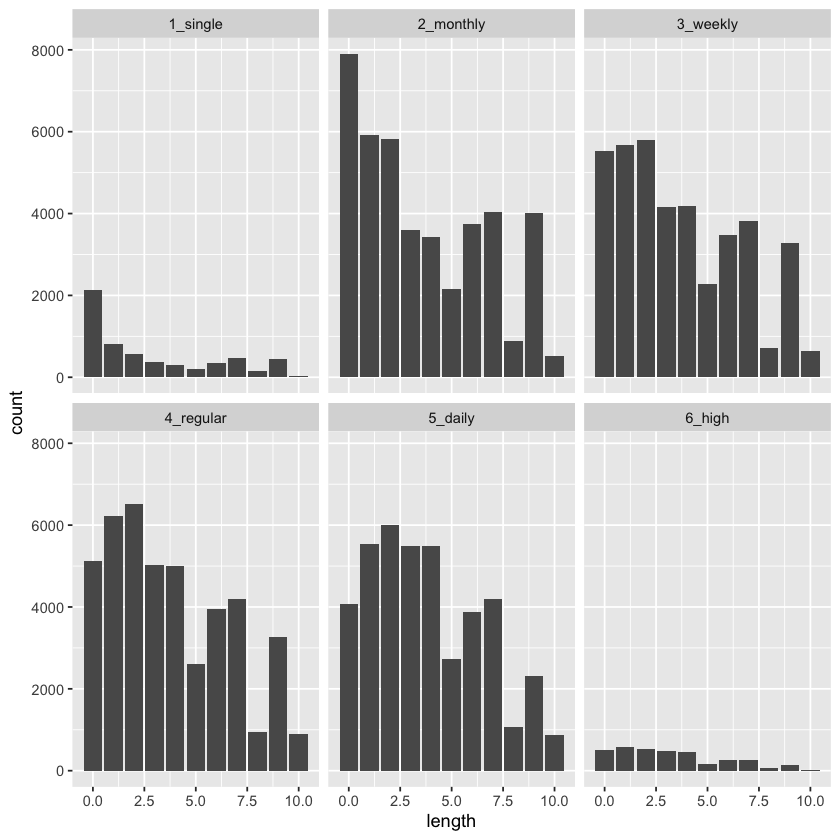

In [4]:
trips %>%
    mutate(onetoll = ifelse(entry_plaza - exit_plaza == 0, 1, 0),
          length = exit_plaza - entry_plaza) %>%
    filter(commercial == 0) %>%
ggplot(aes(x = length)) +
    geom_histogram(stat = "count") +
    facet_wrap(~freq)

In [5]:
block_groups = suppressMessages(st_read("../../data/shapefiles/block_groups/block_groups.shp"))
road_line = st_read("../../data/shapefiles/roads500k/sr500k_20181231.shp") %>%
    filter(RouteID %in% c("005", "090", "099", "167", "405", "520", "522", "527")) %>%
    mutate(color = if_else(RouteID == "405", "red", "black")) %>%
    st_transform(4326)
toll_line = st_zm(road_line) %>%
    filter(RouteID == "405") %>%
    st_crop(xmin=-180, xmax=0, ymin=47.615448, ymax=47.821815)
water = suppressMessages(st_read("../../data/shapefiles/water/water_bodies.shp"))

Reading layer `block_groups' from data source `/Users/cj/DSSG/dssg-hot/data/shapefiles/block_groups/block_groups.shp' using driver `ESRI Shapefile'
replacing null geometries with empty geometries
Simple feature collection with 3166 features and 1 field (with 2 geometries empty)
geometry type:  GEOMETRY
dimension:      XY
bbox:           xmin: -123.2031 ymin: 46.04017 xmax: -119.8656 ymax: 49.00249
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs
Reading layer `sr500k_20181231' from data source `/Users/cj/DSSG/dssg-hot/data/shapefiles/roads500k/sr500k_20181231.shp' using driver `ESRI Shapefile'
Simple feature collection with 280 features and 9 fields
geometry type:  MULTILINESTRING
dimension:      XYM
bbox:           xmin: 637196.4 ymin: 87432.2 xmax: 2514542 ymax: 1353104
epsg (SRID):    NA
proj4string:    +proj=lcc +lat_1=45.83333333333334 +lat_2=47.33333333333334 +lat_0=45.33333333333334 +lon_0=-120.5 +x_0=500000.0000000001 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0

although coordinates are longitude/latitude, st_intersection assumes that they are planar
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”

Reading layer `water_bodies' from data source `/Users/cj/DSSG/dssg-hot/data/shapefiles/water/water_bodies.shp' using driver `ESRI Shapefile'
Simple feature collection with 31 features and 14 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -122.3975 ymin: 47.3226 xmax: -121.1829 ymax: 48.33113
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


In [6]:
trip_sample <- trips_2pct %>%
    execute

Warning message:
“12 parsing failures.
  row col expected actual         file
23087 zip a double v7b1k7 literal data
32084 zip a double V3W7X4 literal data
69739 zip a double V3W7X4 literal data
75337 zip a double V3W7X4 literal data
87441 zip a double V3W7X4 literal data
..... ... ........ ...... ............
See problems(...) for more details.
”

In [7]:
head(trip_sample)

trip_id,def_id,toll,entry_time,exit_time,entry_plaza,exit_plaza,is_hov,tag_id,id,⋯,fips,total_trips,freq,commercial,households,population,mean_inc,med_inc,race_nonhisp_asian,race_nonhisp_white
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
104021670,2689,0.75,1514870207,1514871011,3,12,0,8.705379e+18,-8.855459e+18,⋯,NA,119,3_weekly,0,NA,NA,NA,NA,NA,NA
104021918,2689,0.75,1514881104,1514881907,3,12,0,7.166057e+18,-3.062600e+18,⋯,NA,424,5_daily,0,NA,NA,NA,NA,NA,NA
104022846,2695,0.75,1514870916,1514870965,6,7,0,-4.911980e+18,-3.507431e+18,⋯,NA,38921,6_high,1,NA,NA,NA,NA,NA,NA
104023768,2690,0.00,1514880516,1514880901,3,7,1,7.007863e+18,5.584338e+18,⋯,530330219043,545,5_daily,0,561,1373,108234.5,54219,0.1565914,0.7203205
104024403,2694,0.75,1514893169,1514893805,5,12,0,-2.081369e+18,3.279526e+17,⋯,530330220012,1211,6_high,1,1233,2663,91304.4,62525,0.1096508,0.6793090
104024506,2701,0.00,1514872859,1514873213,19,22,1,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Looking at how frequent the most frequent entry plazas of a fips code occur

In [8]:
fips <- trip_sample %>%
    filter(!is.na(fips)) %>%
    group_by(fips) %>%
    summarize()

In [9]:
# gets the count of the most frequent entry plaza
getmodefreq <- function(v) {
    uniqv <- unique(v)
    max(tabulate(match(v, uniqv)))
}

# gets mode
getMode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

In [10]:
entry_list <- list(proportion = NA)
# appends to global list (sorry :( ) the proportion of the count of the most
# frequent entry_gate for a fips code divided by the total trips in that fips code
fips_entry_count <- function(fips_num) {
    fips_match <- fips$fips[fips_num]
    
    # create dataframe of an ID's trips
    fips_trips <- trip_sample %>%
        filter(fips == fips_match) 
        
    common <- getmodefreq(as.vector(fips_trips$entry_plaza))
    total <- nrow(fips_trips)

    entry <- list(common / total)
                
    entry_list <<- rbindlist(list(entry_list, entry), use.names = TRUE)
}


In [11]:
exit_list <- list(proportion = NA)
fips_exit_count <- function(fips_num) {
    fips_match <- fips$fips[fips_num]
    
    # create dataframe of an ID's trips
    fips_trips <- trip_sample %>%
        filter(fips == fips_match) 
        
    common <- getmodefreq(as.vector(fips_trips$exit_plaza))
    total <- nrow(fips_trips)
    exit <- list(common / total)
                
    exit_list <<- rbindlist(list(exit_list, exit), use.names = TRUE)
}

In [12]:
invisible(lapply(1:nrow(fips), fips_entry_count))

In [13]:
invisible(lapply(1:nrow(fips), fips_exit_count))

Warning message:
“Ignoring unknown parameters: bin_width”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”

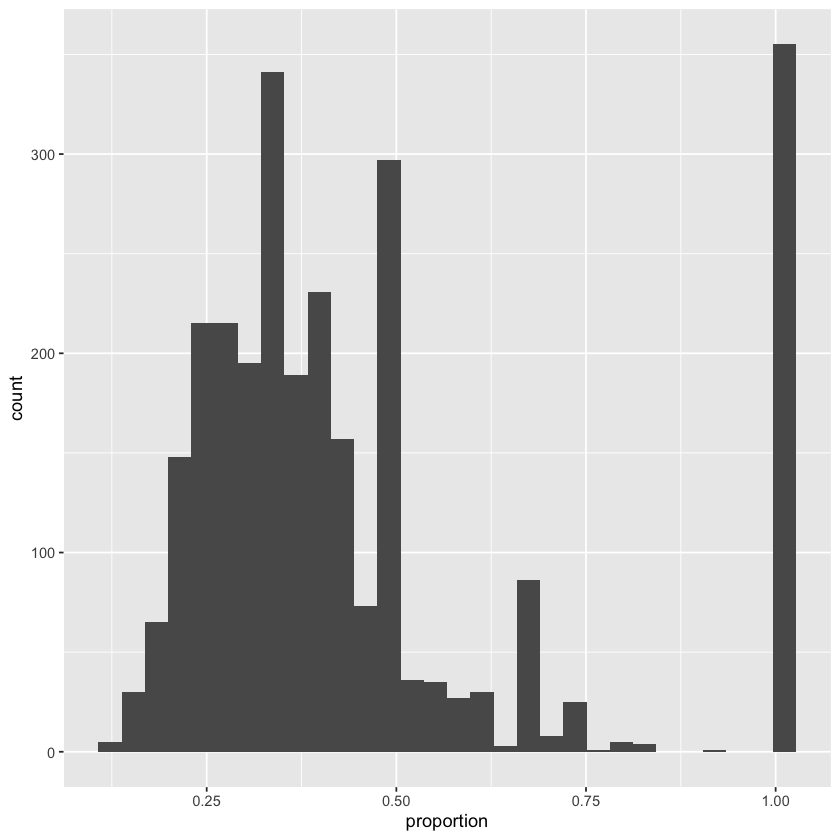

In [14]:
as.data.frame(entry_list) %>%
ggplot() + 
    geom_histogram(aes(x = proportion), bin_width = 10) 

Warning message:
“Ignoring unknown parameters: bin_width”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”

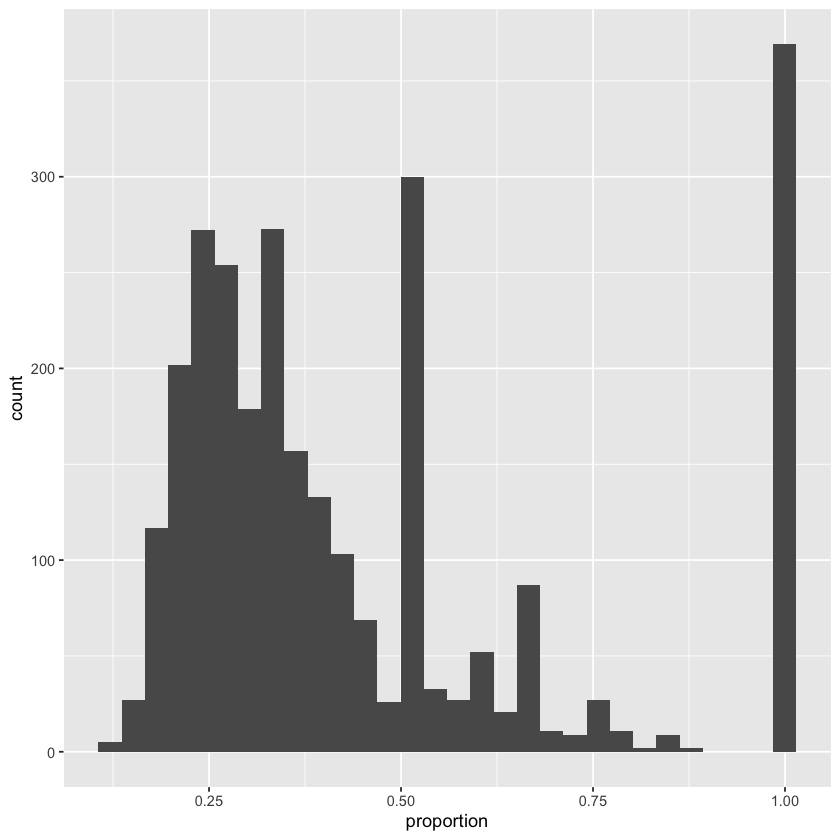

In [15]:
as.data.frame(exit_list) %>%
ggplot() + 
    geom_histogram(aes(x = proportion), bin_width = 10) 

## Mapping The Modal Entry and Exit Plazas

In [16]:
fips_common <- trip_sample %>%
    mutate(direction = ifelse(entry_plaza >= 13, "South", "North")) %>%
    mutate(entry_plaza = ifelse(entry_plaza >= 13, entry_plaza - 12, entry_plaza),
          exit_plaza = ifelse(exit_plaza >= 13, exit_plaza - 12, exit_plaza)) %>%
    group_by(fips, direction) %>%
    summarize(entry_mode = getMode(entry_plaza),
             exit_mode = getMode(exit_plaza))

fips_entry_exit_map <- merge(block_groups, fips_common, by.x = "fips_code", by.y = "fips")

### Most common entry gate by North and South and Entry and Exit

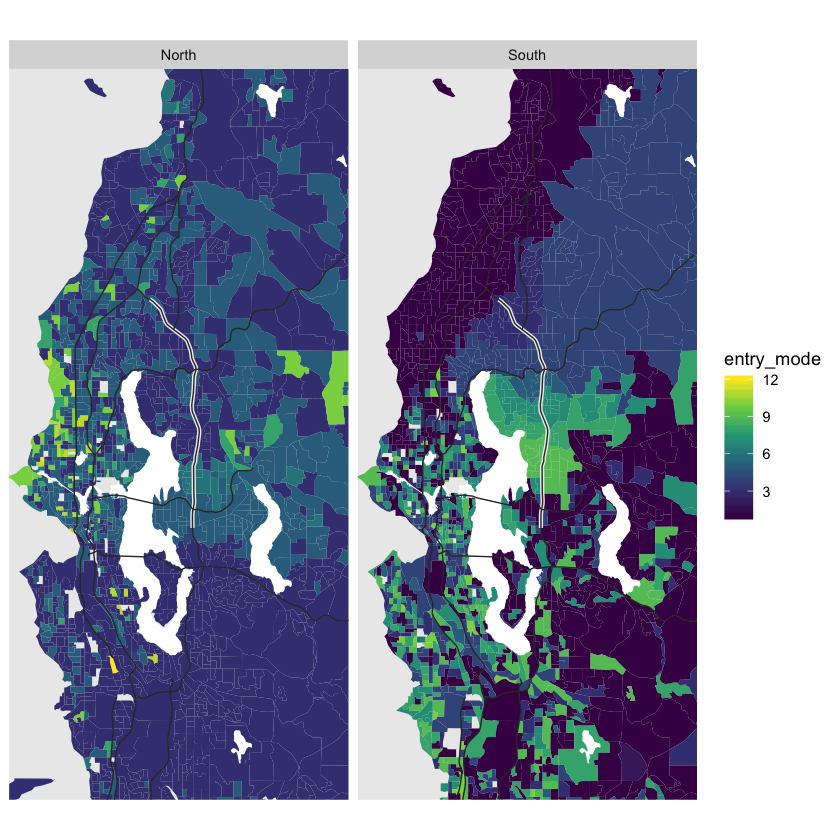

In [17]:
ggplot(fips_entry_exit_map) +
    geom_sf(aes(fill = entry_mode), lwd = 0) +
    scale_fill_viridis_c() +
        geom_sf(fill="white", lwd=0, data=water) + 
        geom_sf(color="#eeeeee", data=toll_line, lwd=1.2) + 
        geom_sf(color="#333333", data=road_line, lwd=0.4) + 
    theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              axis.title.y=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank()) +
    coord_sf(xlim=c(-122.414, -122.0), ylim=c(47.4, 48.0), datum=NA) +
    facet_wrap(~direction)


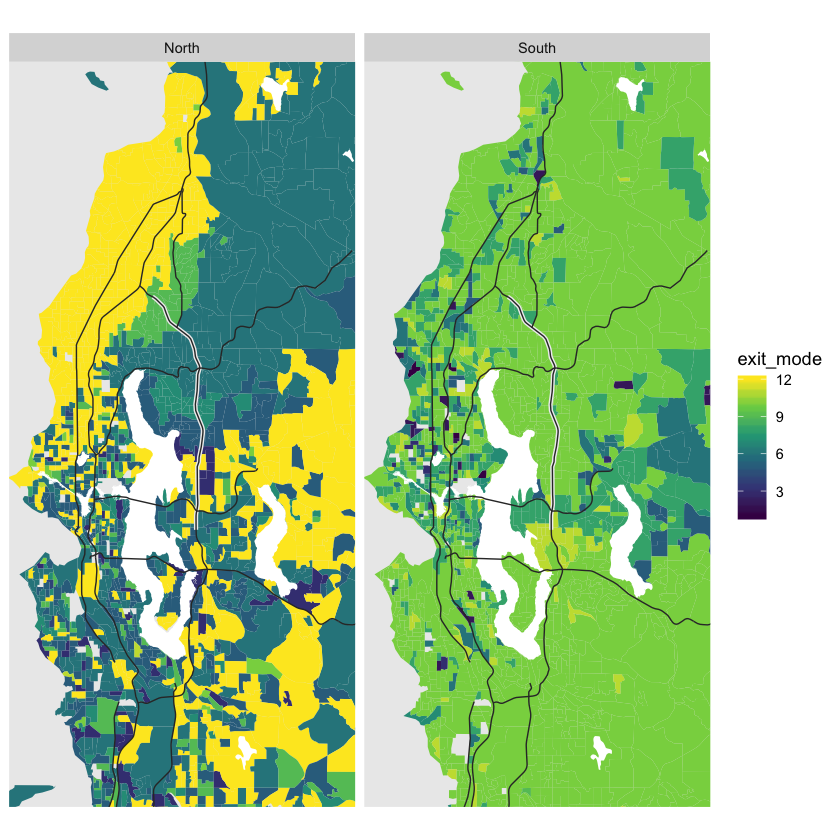

In [18]:
ggplot(fips_entry_exit_map) +
    geom_sf(aes(fill = exit_mode), lwd = 0) +
    scale_fill_viridis_c() +
        geom_sf(fill="white", lwd=0, data=water) + 
        geom_sf(color="#eeeeee", data=toll_line, lwd=1.2) + 
        geom_sf(color="#333333", data=road_line, lwd=0.4) + 
    theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              axis.title.y=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank()) +
    coord_sf(xlim=c(-122.414, -122.0), ylim=c(47.4, 48.0), datum=NA)  +
    facet_wrap(~direction)


In [19]:
fips_common_prop <- trip_sample %>%
    mutate(direction = ifelse(entry_plaza >= 13, "South", "North")) %>%
    group_by(fips, direction) %>%
    summarize(entry_mode_freq = getmodefreq(entry_plaza),
              exit_mode_freq = getmodefreq(exit_plaza),
              total = n(),
              entry_prop = entry_mode_freq / total,
              exit_prop = exit_mode_freq / total)


fips_common_prop_map <- merge(block_groups, fips_common_prop, by.x = "fips_code", by.y = "fips")

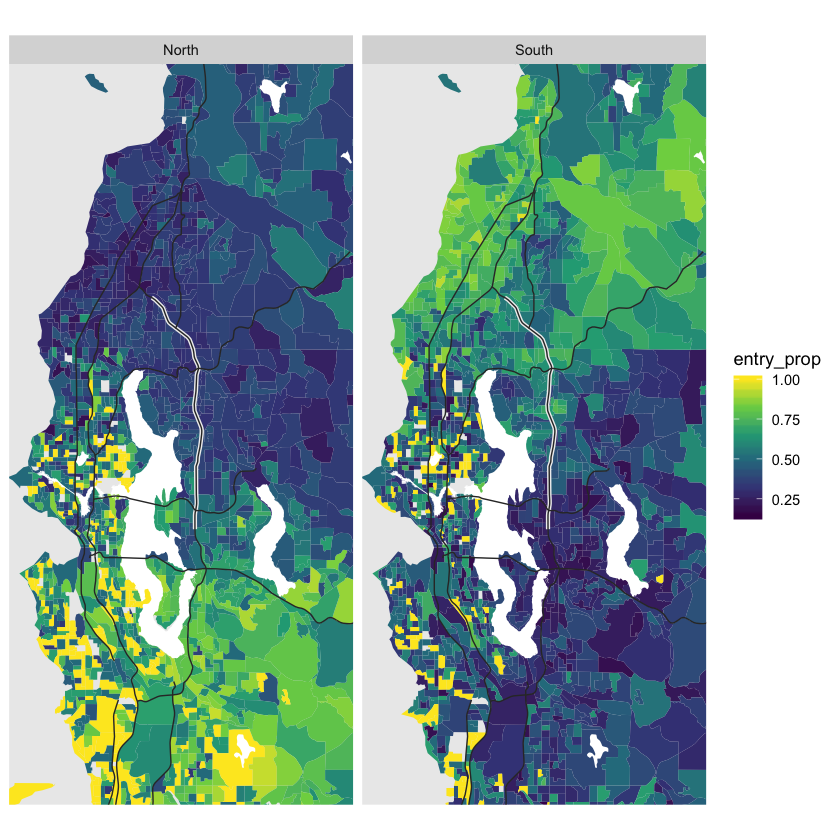

In [20]:
ggplot(fips_common_prop_map) +
    geom_sf(aes(fill = entry_prop), lwd = 0) +
    scale_fill_viridis_c() +
        geom_sf(fill="white", lwd=0, data=water) + 
        geom_sf(color="#eeeeee", data=toll_line, lwd=1.2) + 
        geom_sf(color="#333333", data=road_line, lwd=0.4) + 
    theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              axis.title.y=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank()) +
    coord_sf(xlim=c(-122.414, -122.0), ylim=c(47.4, 48.0), datum=NA) +
    facet_wrap(~direction)

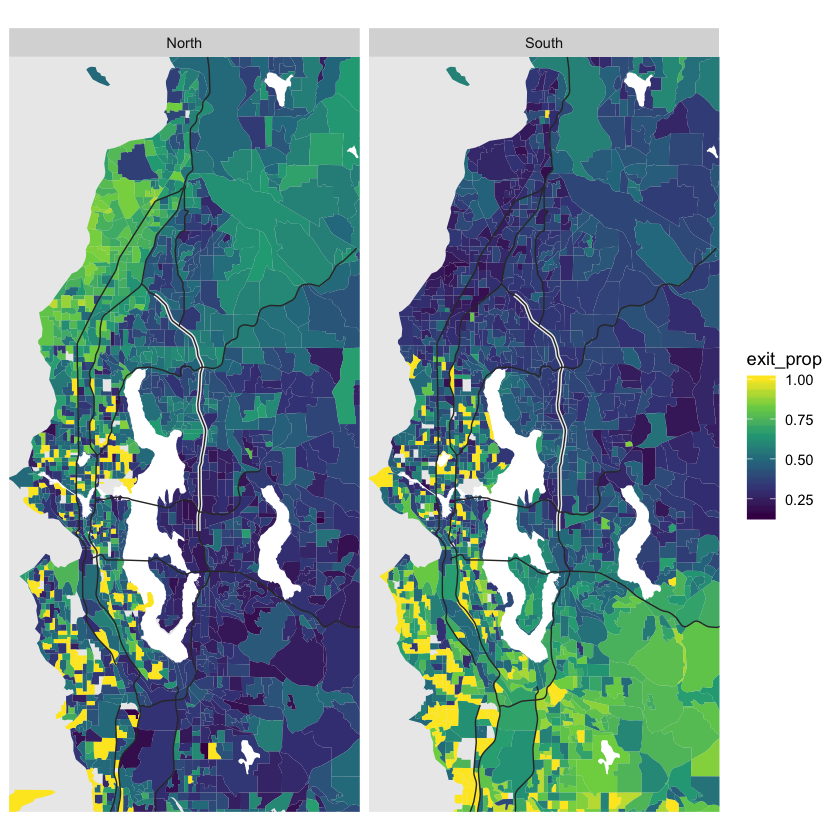

In [21]:
ggplot(fips_common_prop_map) +
    geom_sf(aes(fill = exit_prop), lwd = 0) +
    scale_fill_viridis_c() +
        geom_sf(fill="white", lwd=0, data=water) + 
        geom_sf(color="#eeeeee", data=toll_line, lwd=1.2) + 
        geom_sf(color="#333333", data=road_line, lwd=0.4) + 
    theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              axis.title.y=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank()) +
    coord_sf(xlim=c(-122.414, -122.0), ylim=c(47.4, 48.0), datum=NA) +
    facet_wrap(~direction)